## Advanced VQE Options

We'll learn how to provide more advanced configuration parameters to explore the full range of capabilities of Qiskit's variatiational algorithms, VQE, QAOA, VQD, among others. In particular, this tutorial will cover how to setup a `callback` to monitor convergence and the use of custom `initial_point`s and `gradient`s. 

### Callback

Callback methods can monitor optimization progress as the algorithm runs and converges to a minimum. 

This section demonstrates how to leverage callbacks in `VQE` to plot the convergence path to ground state energies with a selected set of optimizers. 

In [1]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator

H2_op = SparsePauliOp.from_list(
    [
        ("II", -1.052373245772859),
        ("IZ", 0.39793742484318045),
        ("ZI", -0.39793742484318045),
        ("ZZ", -0.01128010425623538),
        ("XX", 0.18093119978423156),
    ]
)

estimator = Estimator() 

Let's compare a set of optimizers using `VQE` callback. The mininum energy of the H2 Hamiltonian can be found quite easily, so the maximum # of iterations (maxiter) does not have to be large. We can again use `TwoLocal` as our ansatz wave equation. 

In [16]:
import numpy as np
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms.utils import algorithm_globals

# iterate over different optimizers 
optimizers = [COBYLA(maxiter=80), L_BFGS_B(maxiter=60), SLSQP(maxiter=60)]
converge_counts = np.empty([len(optimizers)], dtype = object)
converge_vals = np.empty([len(optimizers)], dtype=object)

for i, optimizer in enumerate(optimizers): 
    print(f'{type(optimizer).__name__}')
    algorithm_globals.random_seed = 50
    ansatz = TwoLocal(rotation_blocks= 'ry', entanglement_blocks= 'cz')

    counts = []
    values = []

    def store_intermediate_result(eval_count, parameters, mean, std): 
        counts.append(eval_count)
        values.append(mean)

    vqe = VQE(estimator, ansatz, optimizer, callback=store_intermediate_result)
    result = vqe.compute_minimum_eigenvalue(operator = H2_op)
    converge_counts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)

print('optimization complete')

COBYLA
L_BFGS_B
SLSQP
optimization complete


Now from the callback data we stored, we can plot the energy value at each objective function call each optimizer makes. An optimizer using a finite difference method for computing gradient has a characteristic step-like plot where for a number of evaluations it is computing the value for close by ponts to establish a gradient. 

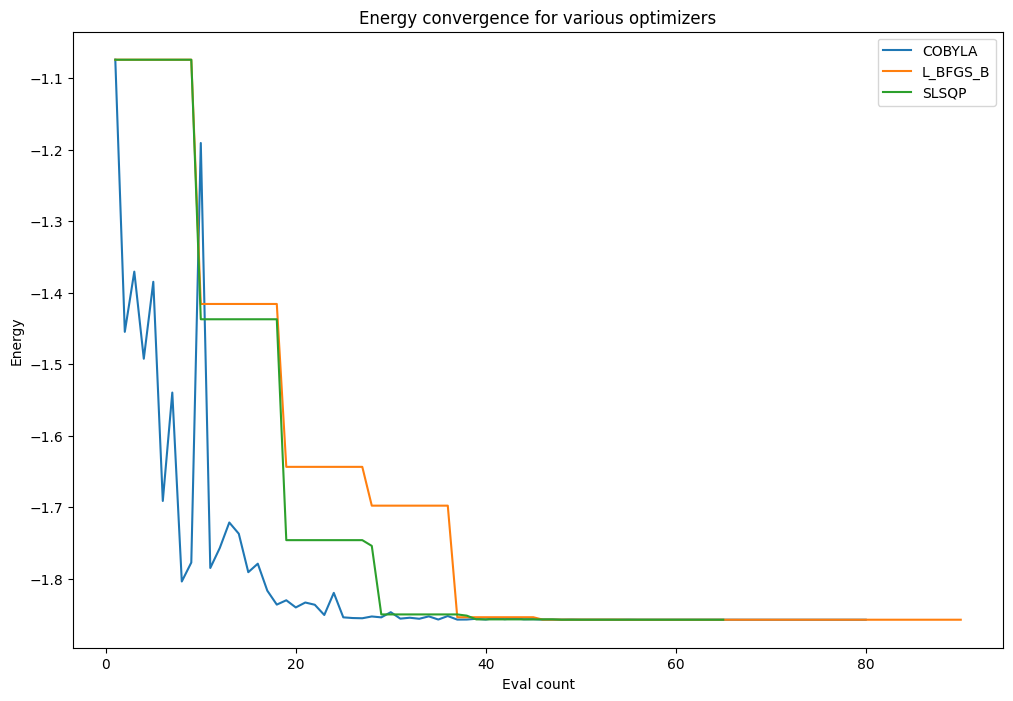

In [17]:
import pylab

pylab.rcParams['figure.figsize'] = (12, 8)

for i, optimizer in enumerate(optimizers): 
    pylab.plot(converge_counts[i], converge_vals[i], label = type(optimizer).__name__)

pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Energy convergence for various optimizers")
pylab.legend(loc="upper right");

Since this problem is still calculable classically, we can also use NumPy's minimum eigensolver to compute a reference value for the solution. 

In [21]:
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()
result = numpy_solver.compute_minimum_eigenvalue(operator = H2_op)
ref_value = result.eigenvalue.real

print(f'reference value: {ref_value}')

reference value: -1.8572750302023786


Let's now compute the difference between the VQE solution and this exact reference as the algorithm converges towards the minimum energy. 

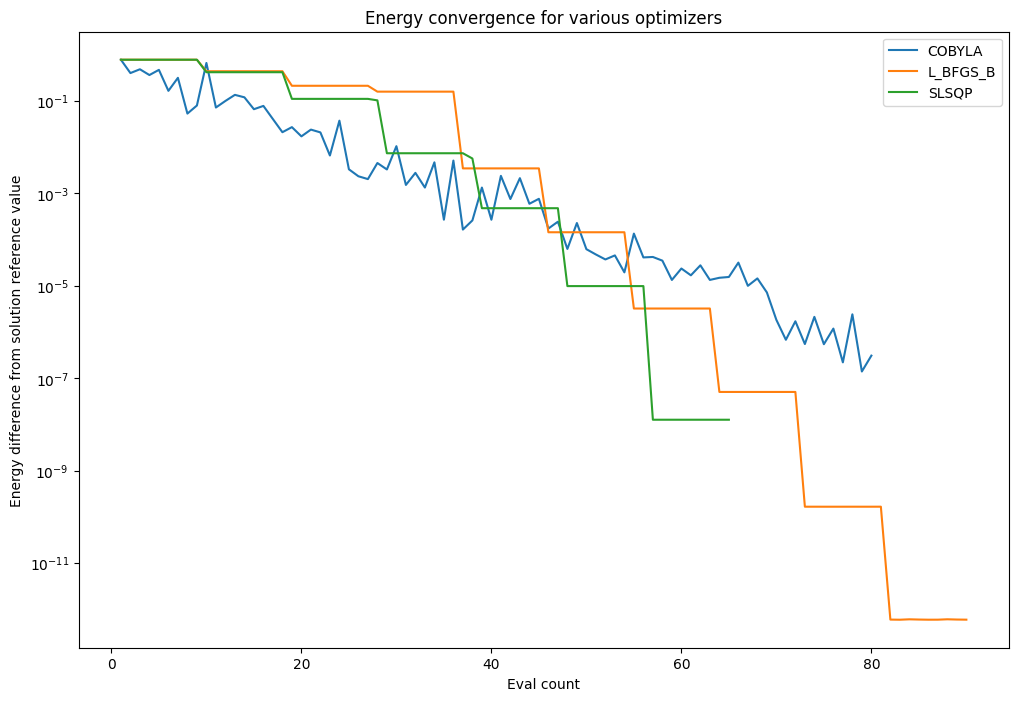

In [28]:
pylab.rcParams["figure.figsize"] = (12, 8)
for i, optimizer in enumerate(optimizers): 
    pylab.plot( 
        converge_counts[i],
        abs(ref_value - converge_vals[i]), 
        label = type(optimizer).__name__
    )

pylab.xlabel("Eval count")
pylab.ylabel("Energy difference from solution reference value")
pylab.title("Energy convergence for various optimizers")
pylab.yscale("log")
pylab.legend(loc="upper right");